# Project: inpainting (MLL)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np

from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error as MSE

from random import sample
from random import shuffle
import time

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import importlib

import usps_tools
import img_tools
import preambule
import patch_predict
import noise_repair
import mpart_repair
importlib.reload(usps_tools)
importlib.reload(img_tools)
importlib.reload(preambule)
importlib.reload(patch_predict)
importlib.reload(noise_repair)
importlib.reload(mpart_repair)
from usps_tools import load_usps,show_usps,normalize
from img_tools import read_img,display_img,display_imgs,channel_normalize,channel_recover,get_patch,get_all_patch
from img_tools import get_patch_bruite,get_dictionnaire,patch_to_vector,vector_to_patch,make_noise
from img_tools import delete_rect,get_noise_pixels_coords,get_true_values,get_hole_pixels_coords
from patch_predict import get_lasso_models, repair_predict, repatching, repair_score, error_rate
from patch_predict import repair_score, error_rate, get_y_test_and_predict

from preambule import Preambule
from noise_repair import Noise_repair
from mpart_repair import Mpart_repair



# 1 Préambule : régression linéaire, régression ridge et LASSO

### *Ontenir une base d’apprentissage et une base de test sur USPS

In [23]:
x_train,y_train = load_usps("USPS/USPS_train.txt")
x_test,y_test = load_usps("USPS/USPS_train.txt")
x_train = normalize(x_train,x_train.min(),x_train.max()) # Normaliser les données
x_test = normalize(x_test,x_test.min(),x_test.max()) # Normaliser les données

### *Creer une instance de Régression linéaire

In [24]:
LR = Preambule("LR")
LR.start_fit(x_train, y_train)
LR_y_predict = LR.predict(x_test)

##### Obtenir le MSE value of Régression linéaire

In [25]:
LR.MSE_score(y_test,LR_y_predict)

2.251131532025785

##### Obtenir le nombre de coefficients null

In [26]:
LR.get_nb_coefs_zero()

0

##### Afficher les distributions de coefficients sur chaque label de y

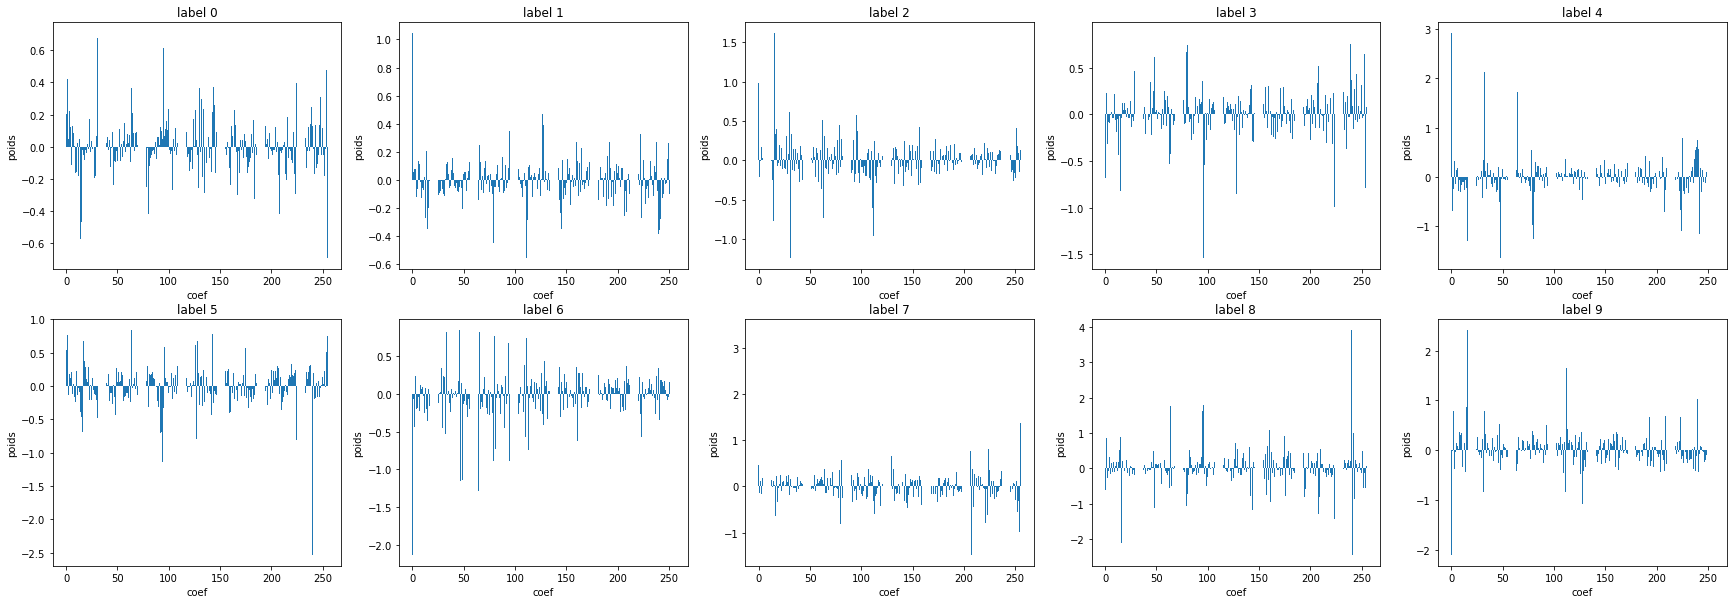

In [27]:
LR.display_poids(16,16)

### *Creer les instances de Ridge (en varier sous alpha)

In [31]:
alphas = [0.000001,0.0001,0.01,0.1]
L2_scores = []
for alpha in tqdm(alphas):
    score = 0
    for _ in range(10):
        Ridge = Preambule("Ridge",alpha)
        Ridge.start_fit(x_train,y_train)
        Ridge_y_predict = Ridge.predict(x_test)
        score += Ridge.L2_score(y_test,Ridge_y_predict)
    L2_scores.append(score/10)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.25s/it]


##### Afficher L2 varier sous alpha

In [32]:
L2_scores

[2.3203707389328216, 2.2498676779741724, 2.329945034141345, 2.478161946902302]

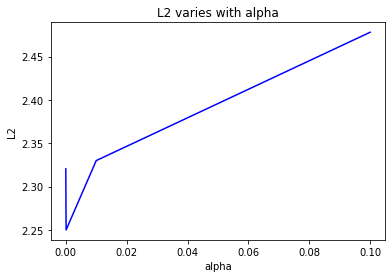

In [33]:
plt.title("L2 varies with alpha")
plt.xlabel('alpha')
plt.ylabel('L2') 
plt.plot(alphas,L2_scores,c="blue")
plt.show()

### *Creer les instances de Lasso (en varier sous alpha)

In [34]:
alphas = [0.000001,0.0001,0.01,0.1]
L1_scores = []
for alpha in tqdm(alphas):
    score = 0
    for _ in range(10):
        Lasso = Preambule("Lasso",alpha)
        Lasso.start_fit(x_train,y_train)
        Lasso_y_predict = Lasso.predict(x_test)
        score += Lasso.L1_score(y_test,Lasso_y_predict)
    L1_scores.append(score/10)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 13.27s/it]


##### Afficher L1 varier sous alpha

In [35]:
L1_scores

[2.2386661154042455, 2.152182202668091, 2.3536437616699564, 6.32005887015434]

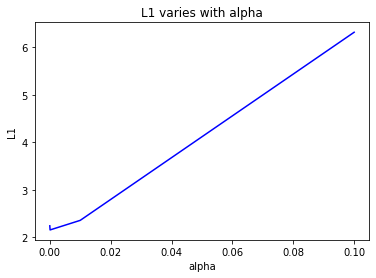

In [36]:
plt.title("L1 varies with alpha")
plt.xlabel('alpha')
plt.ylabel('L1') 
plt.plot(alphas,L1_scores,c="blue")
plt.show()

Lorsque alpha est approximativement égal à 0,001, les modèles Ridge et Lasso sont les meilleurs, ni sous-apprentissage ni sur-apprentissage

### *Observez le nombre de coefficients null dans Ridge et Lasso sous différents alphas 

##### Ridge(alpha = 0.01)

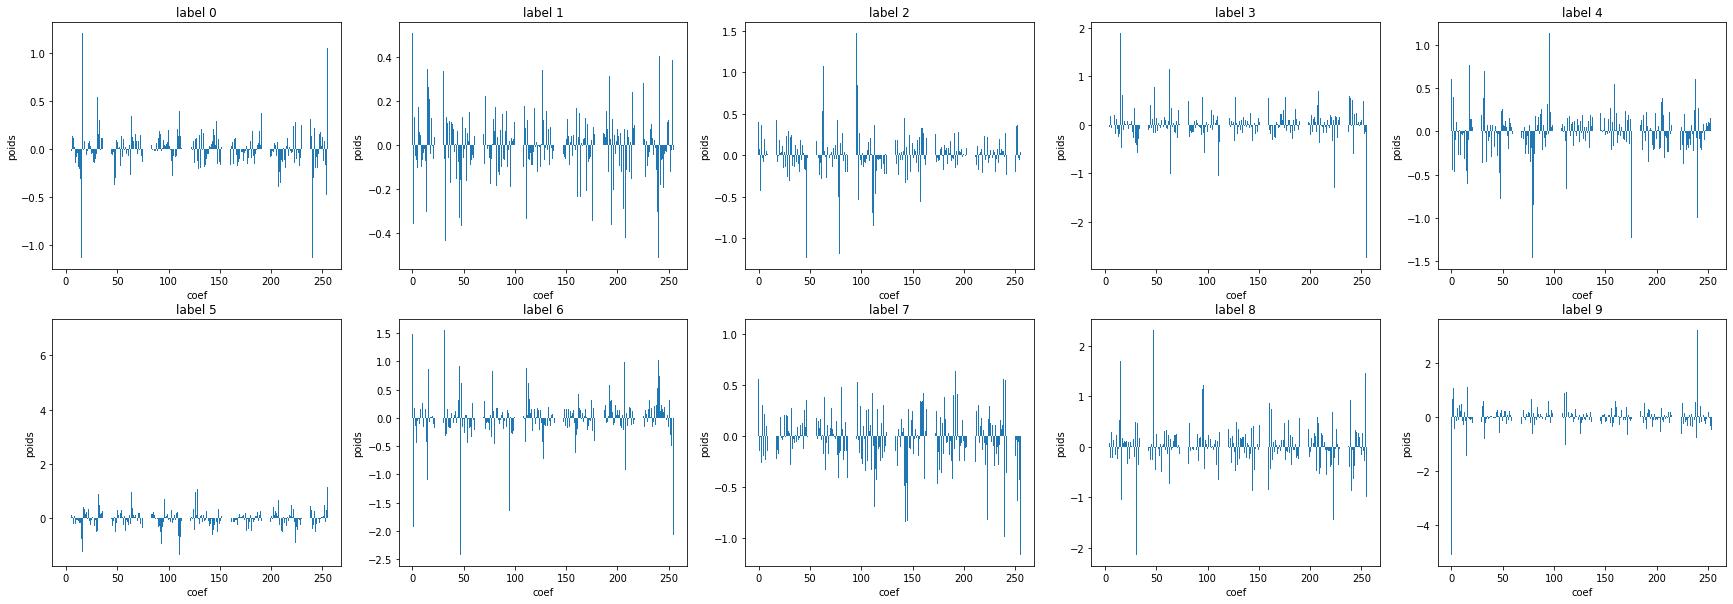

In [37]:
Ridge = Preambule("Ridge",alpha=0.01)
Ridge.start_fit(x_train,y_train)
Ridge.display_poids(16,16)

##### Obtenir le nombre de coefficients null

In [38]:
Ridge.get_nb_coefs_zero()

0

##### Ridge(alpha = 0.1)

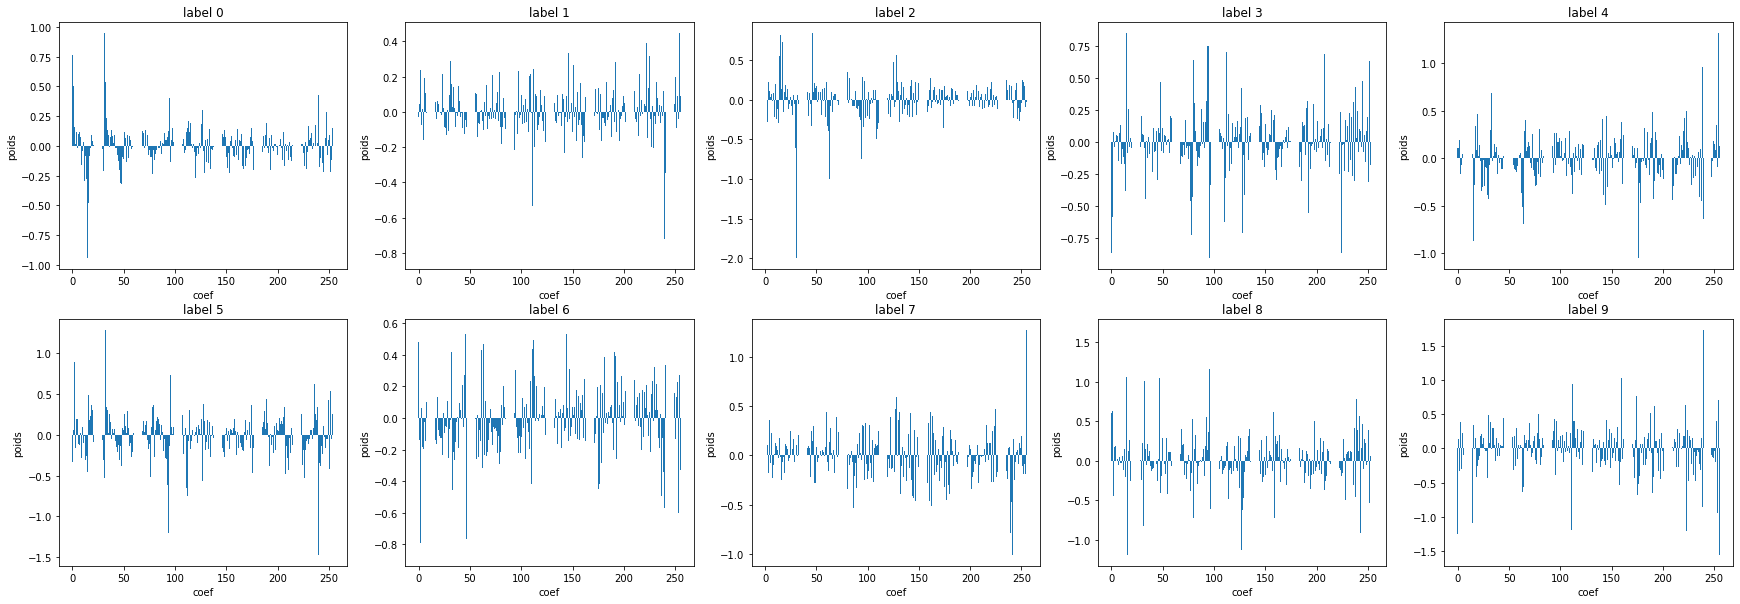

In [39]:
Ridge = Preambule("Ridge",alpha=0.1)
Ridge.start_fit(x_train,y_train)
Ridge.display_poids(16,16)

##### Obtenir le nombre de coefficients null 

In [40]:
Ridge.get_nb_coefs_zero()

0

##### Lasso(alpha = 0.01)

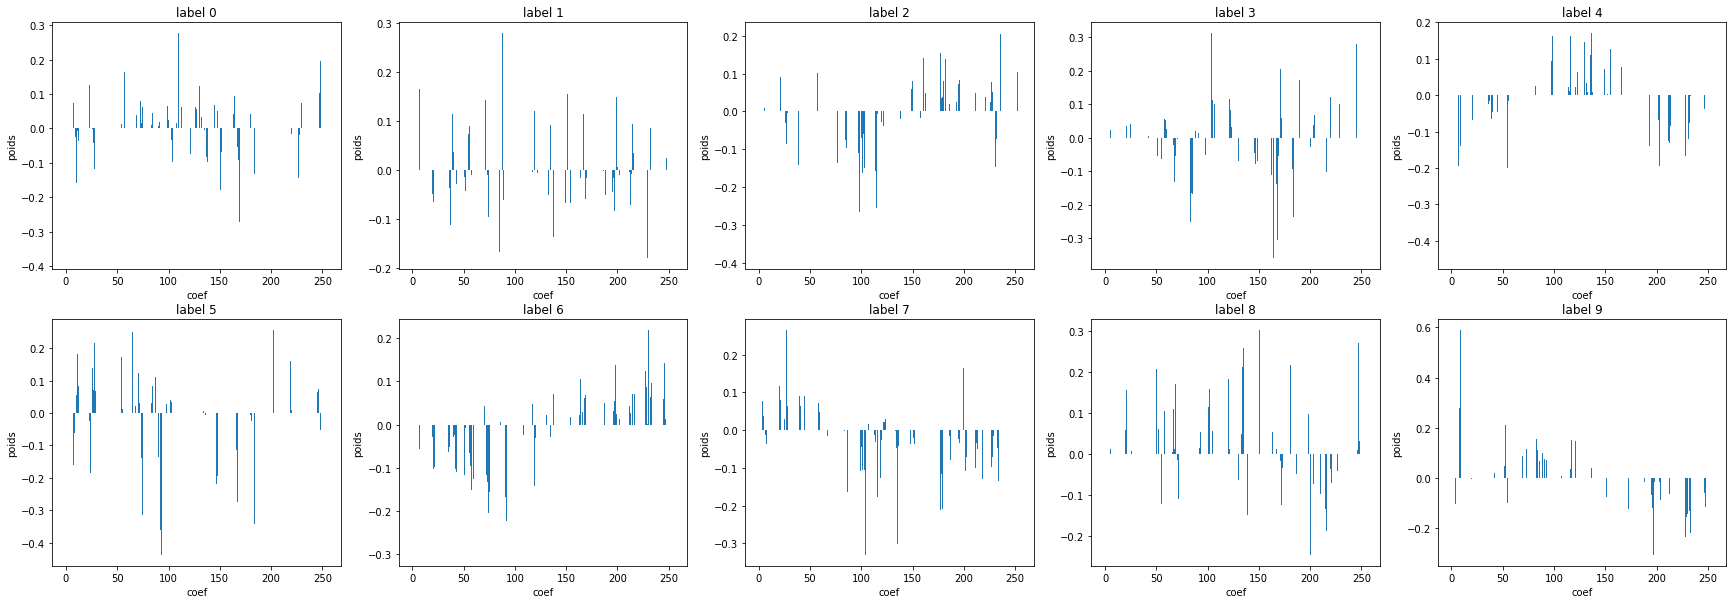

In [41]:
Lasso = Preambule("Lasso",alpha=0.01)
Lasso.start_fit(x_train,y_train)
Lasso.display_poids(16,16)

##### Obtenir le nombre de coefficients null¶

In [42]:
Lasso.get_nb_coefs_zero()

2005

##### Lasso(alpha = 0.1)

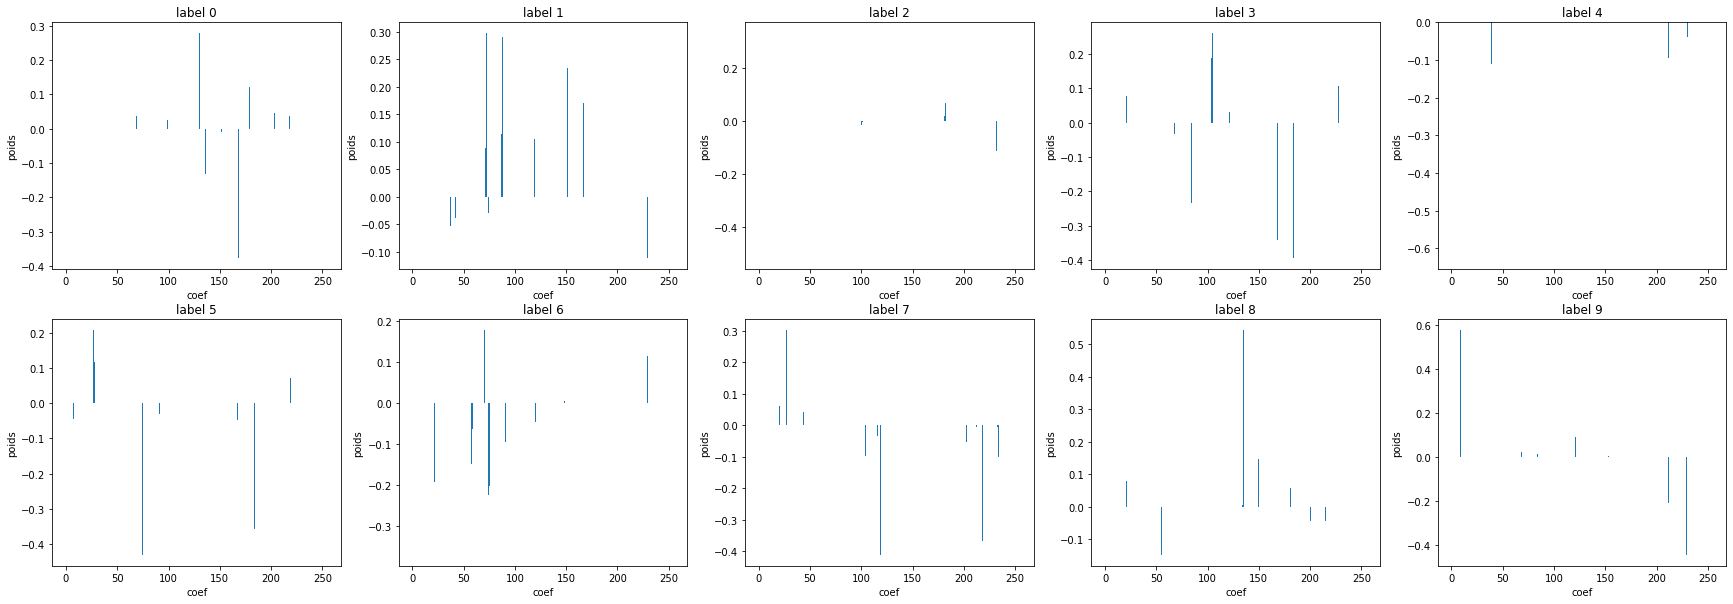

In [43]:
Lasso = Preambule("Lasso",alpha=0.1)
Lasso.start_fit(x_train,y_train)
Lasso.display_poids(16,16)

##### Obtenir le nombre de coefficients null¶¶

In [44]:
Lasso.get_nb_coefs_zero()

2456

Le lasso peut annuler les dimensions qui ont peu d'effet sur le modèle, de sorte que le modèle n'a besoin de prêter attention qu'à quelques dimensions importantes, mais en même temps, trop de punition pour les dimensions non importantes fera également que certaines dimensions importantes changés a des dimensions non importantes, ce qui cause de la sous-apprentissage.

# 2 LASSO et Inpainting

### Utilisez l'image complète comme dictionnaire, réparez un patch bruyant et évaluez les résultats

##### Obtenir l'image original

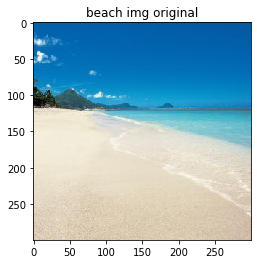

In [3]:
img_array = read_img("test_img/img_beach.jpg")
display_img(img_array,"beach img original")

##### Obtenir dictionnaire

In [46]:
h = 25
d_h = 25
d_w = 25
dictionnaire = get_all_patch(h, channel_normalize(img_array),d_h,d_w)[0]

##### Obtenir une patch original et brutié

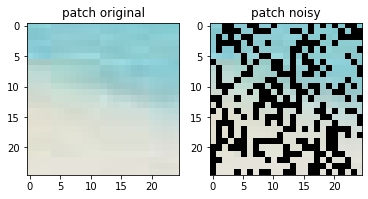

In [47]:
patch = get_patch(150,200,25,img_array)
patch_noise = make_noise(patch,0.4)
display_imgs_array = [patch,patch_noise]
display_titles = ["patch original","patch noisy"]
display_imgs(display_imgs_array,display_titles,1,2)

##### Obtenir les vrais valeurs sur bruite

In [48]:
y_test_rgb = get_true_values(patch_noise, patch)

##### Réparer le bruit sur une patch (en varier sous alpha)

In [49]:
errors = []
img_display_arrays = []
y_predicts = []
alphas = [0.1,0.005,0.001,0.0005,0.0001,]
for alpha in tqdm(alphas):
    models = get_lasso_models(dictionnaire,channel_normalize(patch_noise),alpha,max_iter=1000)
    y_predict_rgb = repair_predict(models,dictionnaire,channel_normalize(patch_noise))
    patch_repaired = repatching(y_predict_rgb, channel_normalize(patch_noise),h)
    score = repair_score(channel_normalize(y_test_rgb),y_predict_rgb)
    error = error_rate(score, channel_normalize(y_test_rgb).mean())
    errors.append(error)
    #img_display_arrays.append(patch)
    #img_display_arrays.append(patch_noise)
    img_display_arrays.append(patch_repaired)
    y_predicts.append(channel_recover(y_predict_rgb))
errors = np.array(errors)
img_display_arrays = np.array(img_display_arrays)
y_predicts = np.array(y_predicts)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.14it/s]


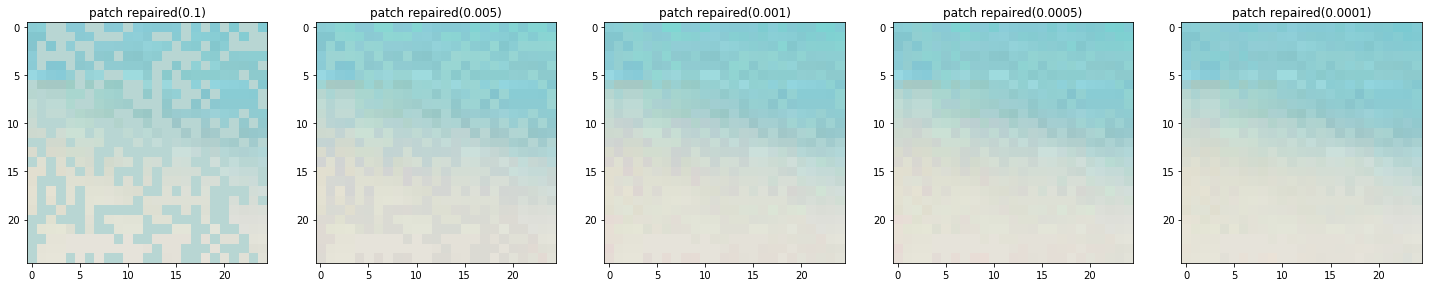

In [50]:
plt.figure(figsize = (25,35))
img_display_titles = ["patch original","patch noisy","patch repaired(alpha=0.1)",
                      "patch original","patch noisy","patch repaired(alpha=0.005)",
                      "patch original","patch noisy","patch repaired(alpha=0.001)",
                      "patch original","patch noisy","patch repaired(alpha=0.0005)",
                      "patch original","patch noisy","patch repaired(alpha=0.0001)",
                      "patch original","patch noisy","patch repaired(alpha=0.00001)",
                      "patch original","patch noisy","patch repaired(alpha=0.0000001)"]
img_display_titles_rep= ["patch repaired(0.1)",
                         "patch repaired(0.005)",
                         "patch repaired(0.001)",
                         "patch repaired(0.0005)",
                         "patch repaired(0.0001)",
                         "patch repaired(0.00001)",
                         "patch repaired(0.0000001)"]
display_imgs(img_display_arrays,img_display_titles_rep,1,5)

##### La relation entre le taux d'erreur fixe et alpha

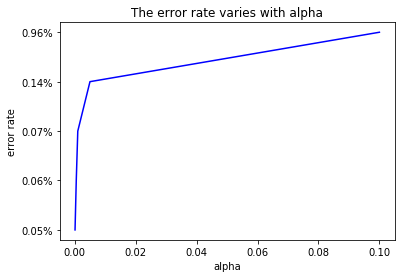

In [51]:
plt.title("The error rate varies with alpha")
plt.xlabel('alpha')
plt.ylabel('error rate')
ax = plt.gca()
ax.invert_yaxis() 
plt.plot(alphas,errors,c="blue")
plt.show()

##### Des graphique montrant la comparaison des valeurs prévues et réelles des trois canaux

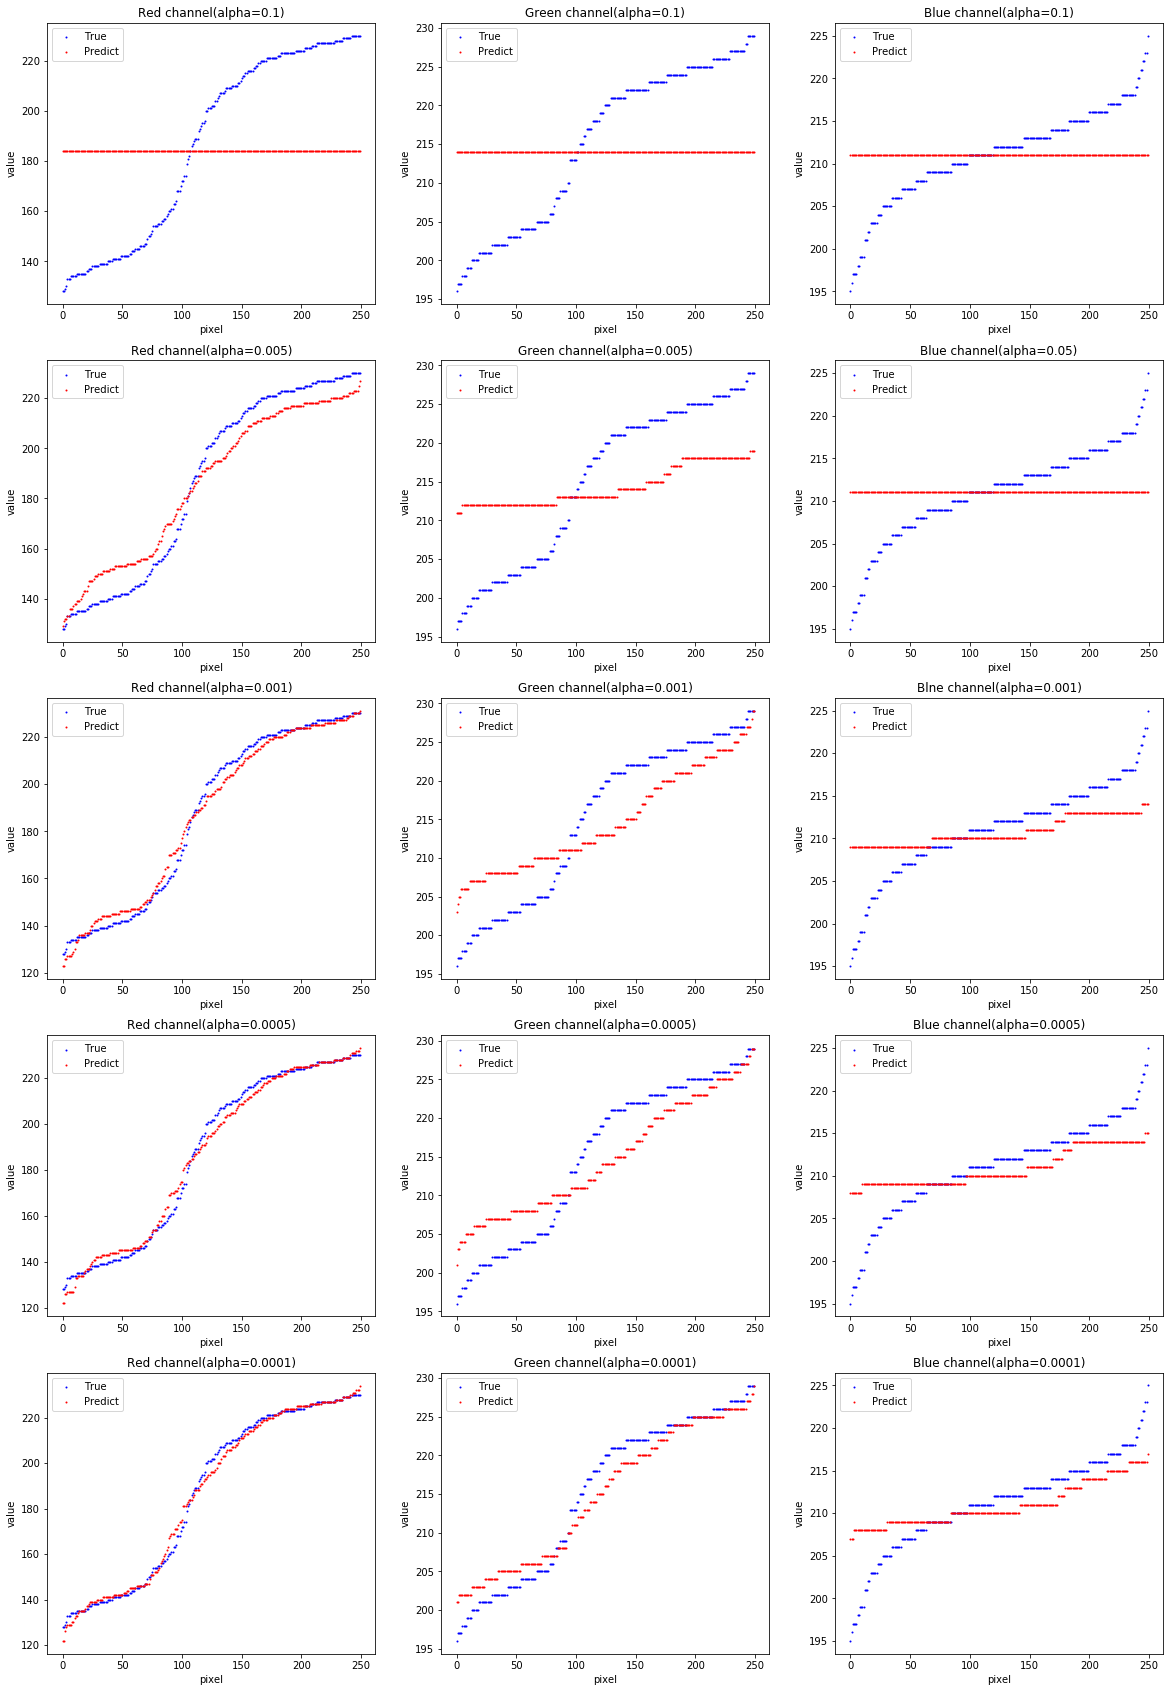

In [52]:
display_titles = [["Red channel(alpha=0.1)","Green channel(alpha=0.1)","Blue channel(alpha=0.1)"],
                  ["Red channel(alpha=0.005)","Green channel(alpha=0.005)","Blue channel(alpha=0.05)"],
                  ["Red channel(alpha=0.001)","Green channel(alpha=0.001)","Blne channel(alpha=0.001)"],
                  ["Red channel(alpha=0.0005)","Green channel(alpha=0.0005)","Blue channel(alpha=0.0005)"],
                  ["Red channel(alpha=0.0001)","Green channel(alpha=0.0001)","Blue channel(alpha=0.0001)"]]
#y_test_rgb_recover = channel_recover(y_test_rgb)
n = 1
for i in range(len(alphas)):
    for j in range(3):
        plt.figure('channels predicts',figsize = (20,30)).add_subplot(5,3,n)
        plt.title(display_titles[i][j])
        plt.xlabel("pixel")
        plt.ylabel("value")
        plt.scatter(range(y_test_rgb.shape[0]),sorted(y_test_rgb[:,j]),s=1,c="blue",label="True")
        plt.scatter(range(y_predicts.shape[1]),sorted(y_predicts[i,:,j]),s=1,c="red",label="Predict")
        plt.legend()
        n+=1
plt.show()


## Réparer les images avec du bruit

##### Obtenir l'image original

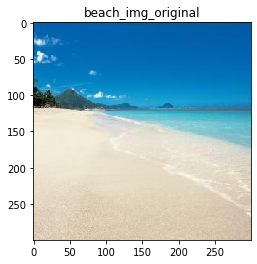

In [53]:
img_array = read_img("test_img/img_beach.jpg")
display_img(img_array,"beach_img_original")

##### Ajouter des bruits sur l'image

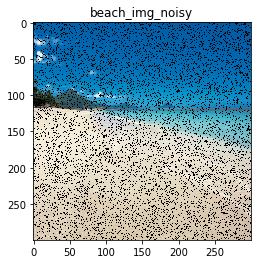

In [54]:
img_array_noise = make_noise(img_array,0.15)
display_img(img_array_noise,"beach_img_noisy")

##### Commencez à réparer, nous avons ici alpha = 0,01, la longueur du côté du patch est de 5 et l'espacement entre les points centraux du patch est également de 5

In [55]:
NP = Noise_repair(img_array_noise,alpha=0.01,max_iter=1000)

In [56]:
h = 5
d_h = d_w = 5
NP.repair(h,d_h,d_w)
img_array_repaired = NP.img_array_repaired

6.63 s


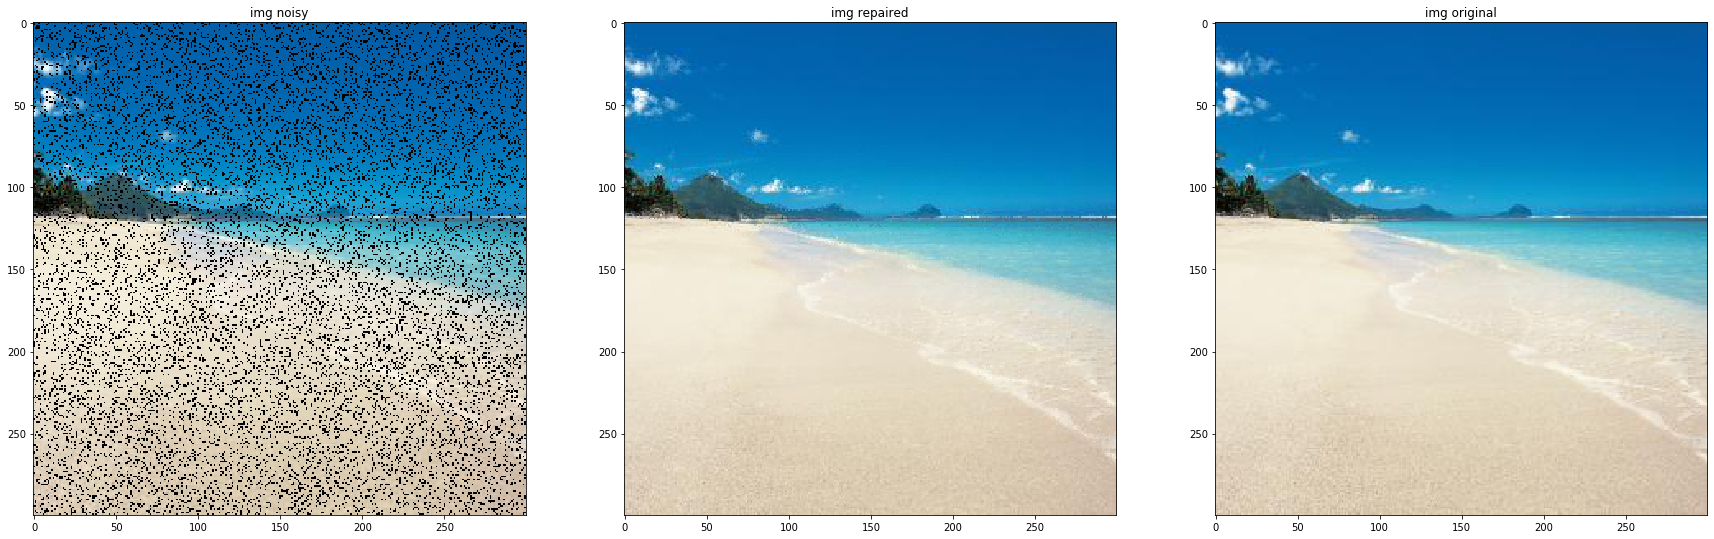

In [57]:
display_arrays = [img_array_noise,img_array_repaired,img_array]
display_titles = ["img noisy","img repaired","img original"]
plt.figure(figsize = (30,30))
display_imgs(display_arrays,display_titles,1,3)

##### Obtenir les valeurs originals et predicts des bruits

In [58]:
y_test, y_predict = get_y_test_and_predict(img_array_noise,img_array,img_array_repaired)

##### Commencer evaluer les resultats 

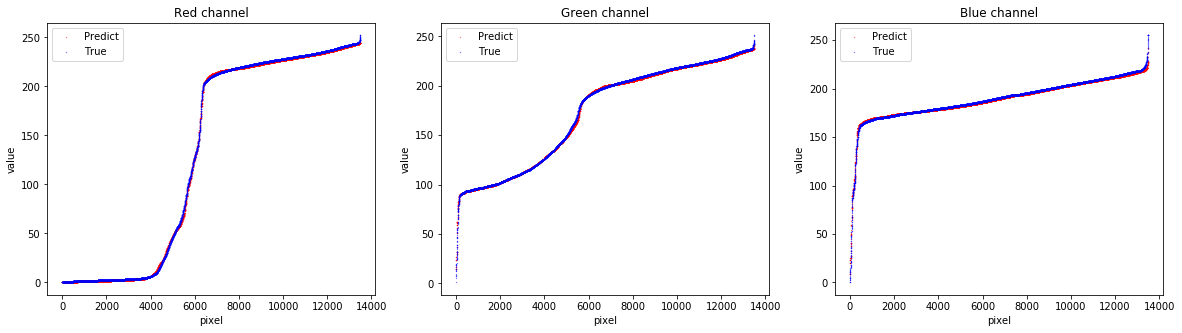

In [59]:
display_titles = ["Red channel","Green channel","Blue channel"]
for j in range(3):
    plt.figure('channels predicts',figsize = (20,5)).add_subplot(1,3,j+1)
    plt.title(display_titles[j])
    plt.xlabel("pixel")
    plt.ylabel("value")
    plt.scatter(range(y_predict.shape[0]),sorted(y_predict[:,j]),s=0.05,c="red",label="Predict")
    plt.scatter(range(y_test.shape[0]),sorted(y_test[:,j]),s=0.05,c="blue",label="True")
    plt.legend()
plt.show()

# Compléter les parties manquantes de l'image

##### Obtenir l'image original

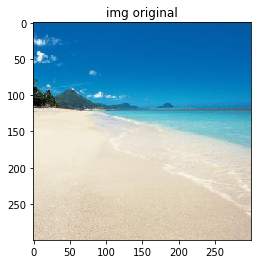

In [60]:
img_array = read_img("test_img/img_beach.jpg")
display_img(img_array,"img original")

##### Détruisez une partie de l'image

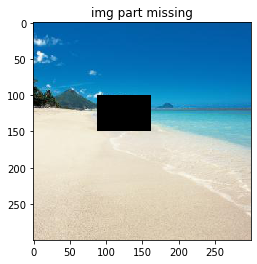

In [61]:
hole_h = 50
hole_w = 75
img_array_hole = delete_rect(img_array,125,125,hole_h,hole_w)
display_img(img_array_hole,"img part missing")

### Compléter

In [62]:
beach_img_repaireds = []
alphas = [0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.0025,0.00005,0.00005,0.00005,0.000005]
hs = [75,75,75,75,25,5,5,5,25,25,75,75]
d_hs = d_ws = [75,75,25,75,25,5,5,5,25,25,75,75]
steps = [25,5,5,1,1,1,1,1,1,5,25,25]
max_iter = [1000,1000,1000,1000,1000,1000,100000,100000,100000,1000000]
i = 0
for step in tqdm(steps):
    MPR = Mpart_repair(img_array_hole,alphas[i],max_iter=1000)
    MPR.repair(step,hs[i],d_hs[i],d_ws[i])
    beach_img_repaireds.append(MPR.img_array_repaired)
    i+=1

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

0.53 s


  8%|██████▉                                                                            | 1/12 [00:00<00:10,  1.03it/s]

18.07 s


 17%|█████████████▊                                                                     | 2/12 [00:19<01:02,  6.27s/it]

25.45 s


 25%|████████████████████▊                                                              | 3/12 [00:45<01:49, 12.19s/it]

593.84 s


 33%|███████████████████████████▎                                                      | 4/12 [10:40<24:54, 186.87s/it]

107.16 s


 42%|██████████████████████████████████▏                                               | 5/12 [12:27<19:02, 163.16s/it]

118.57 s


 50%|█████████████████████████████████████████                                         | 6/12 [14:27<15:00, 150.01s/it]

112.27 s


 58%|███████████████████████████████████████████████▊                                  | 7/12 [16:20<11:34, 138.91s/it]

139.37 s


 67%|██████████████████████████████████████████████████████▋                           | 8/12 [18:40<09:17, 139.28s/it]

178.03 s


 75%|█████████████████████████████████████████████████████████████▌                    | 9/12 [21:39<07:33, 151.13s/it]

7.64 s


 83%|███████████████████████████████████████████████████████████████████▌             | 10/12 [21:47<03:36, 108.27s/it]

1.01 s


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [21:49<01:16, 76.28s/it]

1.19 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [21:50<00:00, 53.93s/it]


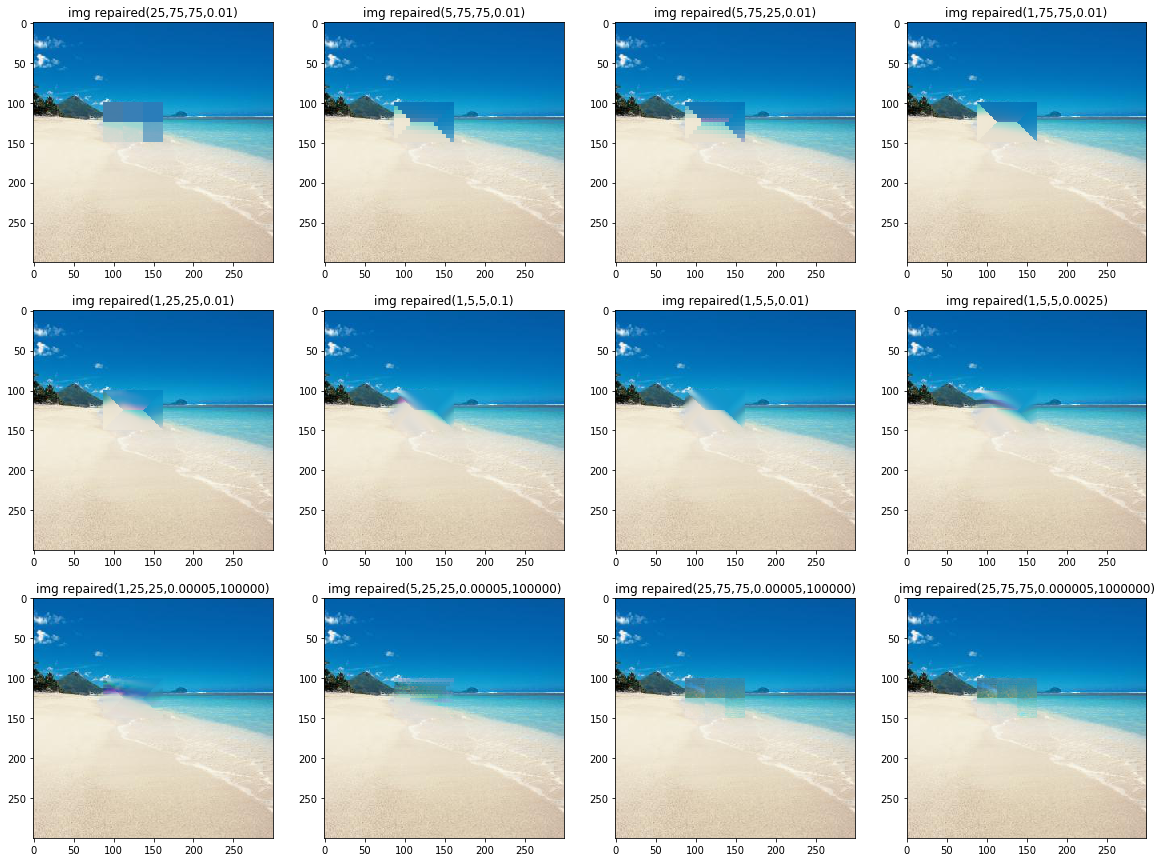

In [63]:
beach_img_display_titles = ["img repaired(25,75,75,0.01)",
                  "img repaired(5,75,75,0.01)",
                  "img repaired(5,75,25,0.01)",
                  "img repaired(1,75,75,0.01)",
                  "img repaired(1,25,25,0.01)",
                  "img repaired(1,5,5,0.1)",
                  "img repaired(1,5,5,0.01)",
                  "img repaired(1,5,5,0.0025)",
                  "img repaired(1,25,25,0.00005,100000)",
                  "img repaired(5,25,25,0.00005,100000)",
                  "img repaired(25,75,75,0.00005,100000)",
                  "img repaired(25,75,75,0.000005,1000000)"]
plt.figure(figsize = (20,15))
display_imgs(beach_img_repaireds, beach_img_display_titles, 3,4)

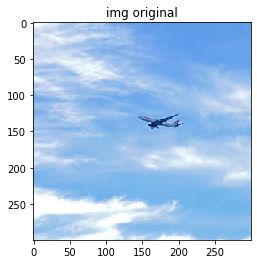

In [64]:
img_array = read_img("test_img/img_sky.jpg")
display_img(img_array,"img original")

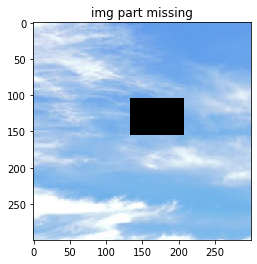

In [65]:
hole_h = 50
hole_w = 75
img_array_hole = delete_rect(img_array,130,170,hole_h,hole_w)
display_img(img_array_hole,"img part missing")

In [66]:
sky_img_repaireds = []
alphas = [0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.0025,0.00005,0.00005,0.00005,0.000005]
hs = [75,75,75,75,25,5,5,5,25,25,75,75]
d_hs = d_ws = [75,75,25,75,25,5,5,5,25,25,75,75]
steps = [25,5,5,1,1,1,1,1,1,5,25,25]
max_iter = [1000,1000,1000,1000,1000,1000,100000,100000,100000,1000000]
i = 0
for step in tqdm(steps):
    MPR = Mpart_repair(img_array_hole,alphas[i],max_iter=1000)
    MPR.repair(step,hs[i],d_hs[i],d_ws[i])
    sky_img_repaireds.append(MPR.img_array_repaired)
    i+=1

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

0.92 s


  8%|██████▉                                                                            | 1/12 [00:01<00:16,  1.47s/it]

24.91 s


 17%|█████████████▊                                                                     | 2/12 [00:26<01:26,  8.68s/it]

32.66 s


 25%|████████████████████▊                                                              | 3/12 [01:00<02:24, 16.06s/it]

619.26 s


 33%|███████████████████████████▎                                                      | 4/12 [11:20<26:17, 197.21s/it]

101.05 s


 42%|██████████████████████████████████▏                                               | 5/12 [13:01<19:39, 168.57s/it]

106.32 s


 50%|█████████████████████████████████████████                                         | 6/12 [14:49<15:00, 150.16s/it]

107.77 s


 58%|███████████████████████████████████████████████▊                                  | 7/12 [16:37<11:28, 137.68s/it]

107.82 s


 67%|██████████████████████████████████████████████████████▋                           | 8/12 [18:26<08:35, 128.94s/it]

180.14 s


 75%|█████████████████████████████████████████████████████████████▌                    | 9/12 [21:27<07:13, 144.52s/it]

6.55 s


 83%|███████████████████████████████████████████████████████████████████▌             | 10/12 [21:34<03:26, 103.32s/it]

0.98 s


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [21:35<01:12, 72.80s/it]

1.01 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [21:37<00:00, 51.44s/it]


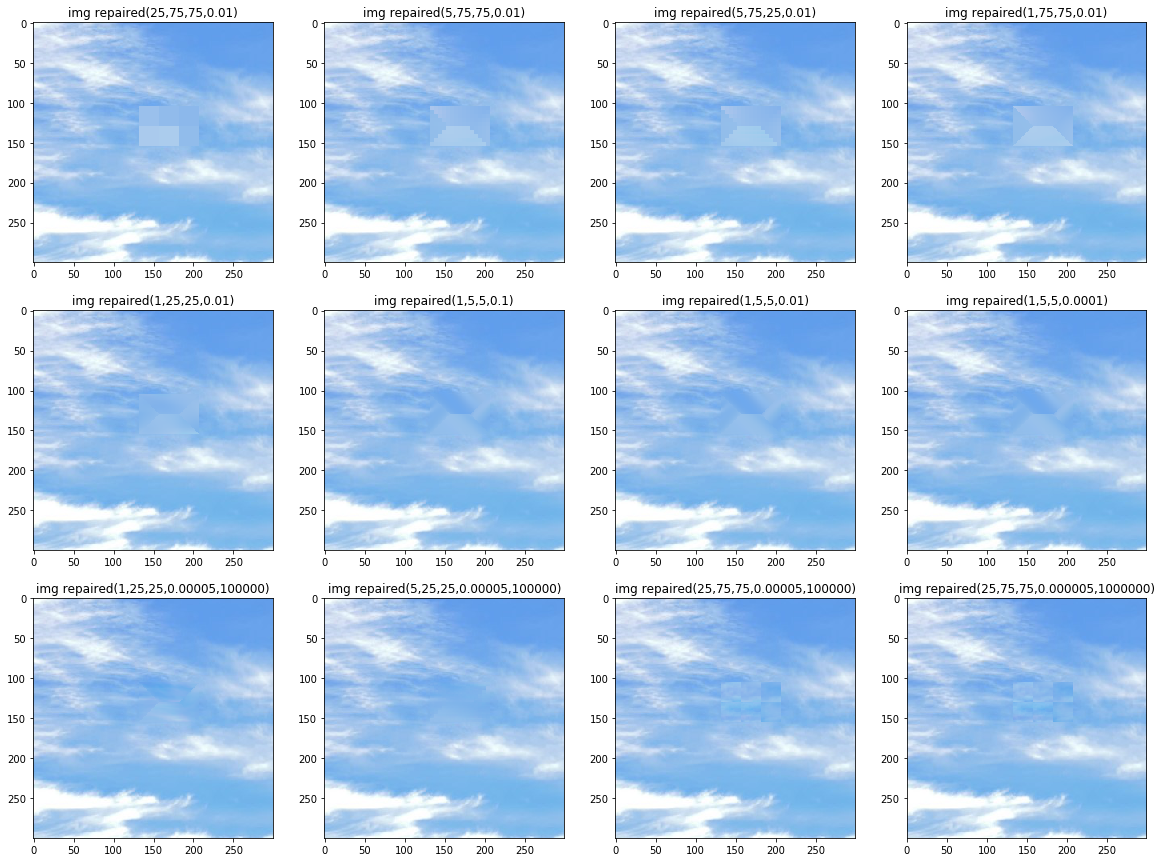

In [67]:
sky_img_display_titles = ["img repaired(25,75,75,0.01)",
                  "img repaired(5,75,75,0.01)",
                  "img repaired(5,75,25,0.01)",
                  "img repaired(1,75,75,0.01)",
                  "img repaired(1,25,25,0.01)",
                  "img repaired(1,5,5,0.1)",
                  "img repaired(1,5,5,0.01)",
                  "img repaired(1,5,5,0.0001)",
                  "img repaired(1,25,25,0.00005,100000)",
                  "img repaired(5,25,25,0.00005,100000)",
                  "img repaired(25,75,75,0.00005,100000)",
                  "img repaired(25,75,75,0.000005,1000000)"]

plt.figure(figsize = (20,15))
display_imgs(sky_img_repaireds, sky_img_display_titles, 3,4)